In [ ]:
 !pip install pydlm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 1.5 MB/s eta 0:00:00


In [ ]:
import math
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.preprocessing import RobustScaler
from keras.models import Sequential
from pydlm import dlm, trend, seasonality, dynamic
from keras.layers import Dense
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error, mean_squared_error

In [57]:
data = pd.read_csv('TSLA.csv')

In [58]:
data.corr().style.format("{:.5}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

<ipython-input-58-0ec218d4fe38>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr().style.format("{:.5}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)


,Open,High,Low,Close,Adj Close,Volume
Open,1.0,0.99971,0.9996,0.99917,0.99917,0.025009
High,0.99971,1.0,0.99961,0.99963,0.99963,0.028913
Low,0.9996,0.99961,1.0,0.99967,0.99967,0.021347
Close,0.99917,0.99963,0.99967,1.0,1.0,0.02598
Adj Close,0.99917,0.99963,0.99967,1.0,1.0,0.02598
Volume,0.025009,0.028913,0.021347,0.02598,0.02598,1.0


In [59]:
df = pd.DataFrame(data)

In [60]:
df = df[['Close','High']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

In [61]:
train_size = int(0.8 * len(df))
test_size = int(0.1 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [62]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

In [63]:
from pydlm import dlm, trend, autoReg, dynamic

# Assuming train_data and y_train are already defined

high_feature = []
for price in train_data['High']:
    high_feature.append([price])

# Define the DLM model
myDLM = dlm(y_train)

# Add a linear trend component with prior covariance 1.0
myDLM = myDLM + trend(1, name='lineTrend', w=1.0)

# Add an autoregressive component with a prior covariance of 1e7
myDLM = myDLM + autoReg(degree=1, data=y_train, name='ar1', w=1e7)

# Add a dynamic component with the high_feature
myDLM = myDLM + dynamic(features=high_feature, discount=1, name='High')

# Fit the DLM model
myDLM.fit()

# Print the fitted model
print(myDLM)

/usr/local/lib/python3.10/dist-packages/pydlm/modeler/autoReg.py:75: UserWarning: The data argument in autoReg is deprecated. Please avoid using it.
  warn('The data argument in autoReg is deprecated. Please avoid using it.')


Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [64]:
# Quá trình testing, and predict test
x_test= []
for price in test_data['High']:
  x_test.append([price])
print(np.array(x_test).shape)
y_test = np.array(test_data['Close'])
y_test_pred = myDLM.predictN(date = myDLM.n-1, N=len(x_test),featureDict={'High': x_test})
y_test_pred = y_test_pred[0]

(300, 1)


In [65]:
mae = mean_absolute_error(y_test, y_test_pred)
mape = mean_absolute_percentage_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)

print("MAE:", mae)
print("MAPE:", mape * 100)
print("RMSE:", rmse)

MAE: 32.508642249471116
MAPE: 10.235045912535465
RMSE: 42.006385661636436


In [66]:
#Quá trình validate, and predict val
y_val = np.array(val_data['High'])
x_val= []
for price in val_data['High']:
  x_val.append([price])
print(type(x_val))
size = test_size + val_size
y_pred_val = myDLM.predictN(featureDict={'High': x_val}, N = len(x_val))
y_pred_val = y_pred_val[0]
print(y_pred_val)

<class 'list'>
[249.5204135299866, 241.12739135171458, 240.89346186398618, 237.30478841395004, 228.79707415337035, 232.1927606319551, 226.39276496221228, 227.02520428607505, 222.31240908613745, 220.09774695985809, 220.21564161679518, 217.30057930372502, 219.9049413883466, 220.9079015467089, 218.7273828528949, 223.14399286524727, 218.9288462302684, 216.68117182903686, 216.9713397631538, 216.48918377976142, 221.82662728996513, 223.529215960117, 224.73359655353653, 222.2443051284647, 223.47617696487785, 226.8323274596603, 221.65104989628549, 219.9816816014905, 221.75866947873186, 214.46509076272332, 210.0419112804623, 211.62551876474248, 209.06780073410653, 212.4380137706082, 211.34518300179133, 214.14124528402263, 209.70180630055484, 207.96536047036577, 208.0879580607354, 204.24935287852458, 202.62217641256913, 209.11719797119545, 208.33869751229548, 210.2166852990323, 208.88094810272696, 213.27918663216613, 214.24228575790113, 212.88188875593445, 211.03131599671852, 208.06945525088858, 

In [67]:
# Thực hiện dự đoán 30 ngày tiếp theo của feature 'High' dựa trên Linear Regression
from sklearn.linear_model import LinearRegression
LR_model = LinearRegression()
LR_model.fit(np.array(train_data.index).reshape(-1,1), train_data['High'])

#Quá trình testing
x_test_LR = np.array(test_data.index).reshape(-1, 1)
y_test_LR = np.array(test_data['High'])
y_pred_LR = LR_model.predict(x_test_LR)

# Quá trình Validate
x_val_LR= np.array(val_data.index).reshape(-1, 1)
y_val_LR = np.array(val_data)
y_pred_val_LR =  LR_model.predict(x_val_LR)

# Predict the prices for the next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

feature_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
feature_next_30_days = LR_model.predict(feature_next_30_days)

print(feature_next_30_days)

[132.74834503 132.80202784 132.85571065 132.90939345 132.96307626
 133.01675907 133.07044188 133.12412469 133.17780749 133.2314903
 133.28517311 133.33885592 133.39253873 133.44622154 133.49990434
 133.55358715 133.60726996 133.66095277 133.71463558 133.76831838
 133.82200119 133.875684   133.92936681 133.98304962 134.03673242
 134.09041523 134.14409804 134.19778085 134.25146366 134.30514646]


In [68]:
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x = []
for price in feature_next_30_days:
  x.append([price])
print(type(x))
num_dims = np.ndim(x)
print(num_dims)
y_next_30_days = myDLM.predictN(featureDict={'High': x}, N = 30)
y_next_30_days = y_next_30_days[0]
print(y_next_30_days)

<class 'list'>
2
[176.51856508621373, 186.57595070713666, 184.17617344480402, 184.94688095580904, 184.9106652699217, 185.07982040024476, 185.1967064022129, 185.3268954714298, 185.4536987639216, 185.58136377377664, 185.70880946709832, 185.8363109788865, 185.96379828426188, 186.09128920532538, 186.21877920615657, 186.34626944119694, 186.4737596166285, 186.6012498072312, 186.72873999397268, 186.85623018169684, 186.9837203691709, 187.11121055670864, 187.2387007442302, 187.36619093175582, 187.4936811192804, 187.62117130680528, 187.7486614943301, 187.8761516818549, 188.0036418693797, 188.1311320569045]


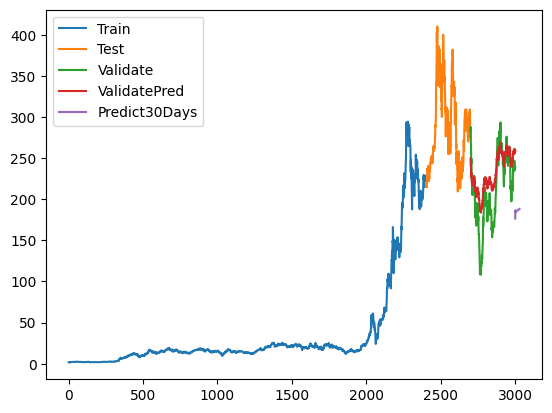

In [69]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index,val_data['Close'])
plt.plot(val_data.index,y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Validate','ValidatePred','Predict30Days'])
plt.show()